<h1>Prediction of Blight fine payment.</h1>
<p>Train a model to predict blight ticket compliance in Detroit. Data contains 250306 rows and 34 columns.</p>

<h3>Results: Final Area Under the ROC Curve</h3>
<p>The final values obtained for the ROC area shown in the table below.</p>
<table>
    <tr>
        <th>Classifier</th>
        <th>ROC area</th>
    </tr>
    <tr>
        <td>Naive Bayes</td>
        <td>0.76</td>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>0.78</td>
    </tr>
    <tr>
        <td>KNN</td>
        <td>0.73</td>
    </tr>
    <tr>
        <td><strong>Random Forest</strong></td>
        <td><strong>0.83</strong></td>
    </tr>
    <tr>
        <td>SVC (linear)</td>
        <td>0.56</td>
    </tr>
    <tr>
        <td>SVC (rbf)</td>
        <td>0.66</td>
    </tr>    
    <tr>
        <td>Xtreme Gradient Boosting</td>
        <td>0.82</td>
    </tr>
</table>   
 
<h2>Background</h2>
<p>
    The Michigan Data Science Team (<a href="http://midas.umich.edu/mdst/">MDST</a>) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (<a href="https://sites.lsa.umich.edu/mssiss/">MSSISS</a>)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. <strong><a href="http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs">Blight violations</a> are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?</strong>

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.</p>

<br>

<h2> Evaluation </h2>

<p>Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points. For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.</p>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant



<h1>Part I: General data cleaning</h1>

Import standard libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Read in training, address, geographic coordinates, and test data

In [2]:
df = pd.read_csv('train.csv', engine='python')
df_address = pd.read_csv('addresses.csv')
df_lat = pd.read_csv('latlons.csv')
df_test = pd.read_csv('test.csv')

Peek at the data to get a sense of it

In [3]:
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [4]:
df_address.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [5]:
df_lat.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


So it looks like we need to use the ticket_id column to look up addresses and use addresses to get latitude and longitude information. 

Let's look more closely at the data types

In [6]:
df_lat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121769 entries, 0 to 121768
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  121769 non-null  object 
 1   lat      121762 non-null  float64
 2   lon      121762 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


In [7]:
df_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ticket_id  311307 non-null  int64 
 1   address    311307 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB


Address has no nulls which is good. Latitude and Longitude have only 7 missing values. We're not so lucky with the training data. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61001 entries, 0 to 61000
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticket_id                   61001 non-null  int64  
 1   agency_name                 61001 non-null  object 
 2   inspector_name              61001 non-null  object 
 3   violator_name               60973 non-null  object 
 4   violation_street_number     61001 non-null  float64
 5   violation_street_name       61001 non-null  object 
 6   violation_zip_code          24024 non-null  object 
 7   mailing_address_str_number  59987 non-null  object 
 8   mailing_address_str_name    60998 non-null  object 
 9   city                        61000 non-null  object 
 10  state                       60670 non-null  object 
 11  zip_code                    60998 non-null  object 
 12  non_us_str_code             0 non-null      float64
 13  country                     610

<h2>Handling missing data</h2>

For latitude and longitude, only 7 missing values so we can just fill them with the mean

In [10]:
df_lat['lat'].fillna((df_lat['lat'].mean()), inplace=True)
df_lat['lon'].fillna((df_lat['lon'].mean()), inplace=True)

Show training data missing values

In [11]:
df.isnull().sum().sort_values(ascending = False)

violation_zip_code            250306
grafitti_status               250305
non_us_str_code               250303
collection_status             213409
payment_date                  209193
compliance                     90426
hearing_date                   12491
mailing_address_str_number      3602
state                             93
violator_name                     34
mailing_address_str_name           4
fine_amount                        1
zip_code                           1
violation_street_number            0
country                            0
inspector_name                     0
city                               0
agency_name                        0
violation_street_name              0
violation_code                     0
ticket_issued_date                 0
compliance_detail                  0
violation_description              0
disposition                        0
admin_fee                          0
state_fee                          0
late_fee                           0
d

Test data missing values

In [12]:
df_test.isnull().sum().sort_values(ascending = False)

non_us_str_code               61001
grafitti_status               58780
violation_zip_code            36977
hearing_date                   2197
mailing_address_str_number     1014
state                           331
violator_name                    28
mailing_address_str_name          3
zip_code                          3
city                              1
agency_name                       0
inspector_name                    0
violation_street_number           0
violation_street_name             0
country                           0
judgment_amount                   0
ticket_issued_date                0
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
ticket_id                         0
dtype: int64

Drop rows with missing compliance as this is target variable.

In [13]:
df.dropna(subset=['compliance'],inplace=True)

Next, Drop columns in training data that are missing from test data as there is no reasonable way to fill in values.

In [14]:
df.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [15]:
df_test.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status'],
      dtype='object')

In [16]:
column_names = df_test.columns.to_list()
column_names.append("compliance")
df_train = df[column_names]

In [17]:
df_train.isnull().sum().sort_values(ascending = False)

violation_zip_code            159880
grafitti_status               159880
non_us_str_code               159877
mailing_address_str_number      2558
hearing_date                     227
state                             84
violator_name                     26
mailing_address_str_name           3
zip_code                           1
compliance                         0
agency_name                        0
inspector_name                     0
violation_street_number            0
violation_street_name              0
city                               0
country                            0
ticket_issued_date                 0
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
t

violation_zip_code ,grafitti_status, and non_us_str_code have too many missing values so let's drop these columns as no reasonable way to fill them. Drop columns in both training and test data. We can also drop violator name

In [18]:
df_train['train_test'] = 1
df_test['train_test'] = 0
data = pd.concat([df_train,df_test])

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
data.tail()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance,train_test
60996,376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,NaN,0
60997,376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,NaN,0
60998,376499,Detroit Police Department,"BOWLES, TIFFANI","BARLOW, CHRISTOPHER D",11832.0,KILBOURNE,48213,11832,KILBOURNE,DETROIT,...,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,NaN,0
60999,376500,Detroit Police Department,"BOWLES, TIFFANI","WILLIAMS, JASON",11848.0,KILBOURNE,48213,4317,YORKSHIRE,DETROIT,...,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,NaN,0
61000,369851,Department of Public Works,"Johnson, Valentina","LEONARD , KENNETH AND JEAN",6100.0,IRONWOOD,48210,71,TYLER,DETROIT,...,50.0,20.0,10.0,0.0,0.0,0.0,80.0,NaN,NaN,0


In [20]:
to_drop = ['grafitti_status', 'violation_zip_code', 'non_us_str_code','violator_name' ]
data.drop(columns=to_drop, axis=1,inplace=True)

In [21]:
data.columns[data.isna().any()]

Index(['mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'hearing_date', 'compliance'],
      dtype='object')

Merge address and latitude dataframes, then merge to combined train and test data

In [22]:
merged_address = pd.merge(df_address, df_lat, how='left', left_on='address', right_on='address')
all_data = pd.merge(data, merged_address, how='left', left_on='ticket_id', right_on='ticket_id')

<strong>Note: lat/lon corresponds to location of offence, not mailing address</strong>

In [23]:
all_data.head()

,ticket_id,agency_name,inspector_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,train_test,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",2900.0,TYLER,3,S. WICKER,CHICAGO,IL,60606,...,10.0,25.0,0.0,0.0,305.0,0.0,1,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",4311.0,CENTRAL,2959,Martin Luther King,Detroit,MI,48208,...,10.0,75.0,0.0,0.0,855.0,1.0,1,"4311 central, Detroit MI",42.326937,-83.135118
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",6478.0,NORTHFIELD,2755,E. 17TH,LOG BEACH,CA,908041512,...,10.0,25.0,0.0,0.0,305.0,0.0,1,"6478 northfield, Detroit MI",42.145257,-83.208233
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",8027.0,BRENTWOOD,476,Garfield,Clinton,MI,48038,...,10.0,75.0,0.0,0.0,855.0,0.0,1,"8027 brentwood, Detroit MI",42.433466,-83.023493
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",8228.0,MT ELLIOTT,8228,Mt. Elliott,Detroit,MI,48211,...,10.0,10.0,0.0,0.0,140.0,0.0,1,"8228 mt elliott, Detroit MI",42.388641,-83.037858


In [24]:
all_data.isnull().sum().sort_values(ascending = False)

compliance                    61001
mailing_address_str_number     3572
hearing_date                   2424
state                           415
mailing_address_str_name          6
zip_code                          4
city                              1
lon                               0
agency_name                       0
inspector_name                    0
violation_street_number           0
violation_street_name             0
country                           0
ticket_issued_date                0
violation_code                    0
lat                               0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
train_test                        0
address                           0
ticket_id                   

Before deciding on a strategy to handle the remaining missing values, let's do some data exploration. Mailing adresses  and zip codes might not be very useful, and it might be better to change hearing date to months, etc.

<h1>Part II: Exploratory Data Analysis</h1>

In [25]:
all_data.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violation_street_number',
       'violation_street_name', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code', 'country',
       'ticket_issued_date', 'hearing_date', 'violation_code',
       'violation_description', 'disposition', 'fine_amount', 'admin_fee',
       'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'compliance', 'train_test', 'address', 'lat', 'lon'],
      dtype='object')

In [26]:
all_data.describe().columns

Index(['ticket_id', 'violation_street_number', 'fine_amount', 'admin_fee',
       'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'compliance', 'train_test', 'lat', 'lon'],
      dtype='object')

In [27]:
all_data.nunique().sort_values()

state_fee                          1
admin_fee                          1
train_test                         2
compliance                         2
agency_name                        5
country                            5
disposition                        8
discount_amount                   15
late_fee                          54
state                             59
fine_amount                       63
inspector_name                   217
violation_code                   223
violation_description            244
clean_up_cost                    298
judgment_amount                  513
violation_street_name           1784
zip_code                        5078
city                            6040
hearing_date                    9249
violation_street_number        19028
mailing_address_str_number     23793
mailing_address_str_name       40018
lat                            77007
lon                            85564
address                        99795
ticket_issued_date            101161
t

Extract interesting numerical columns to look at distributions

In [28]:
df_numerical = df_train[['fine_amount', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount']]

<h3>Plot distribution of categorical columns</h3>

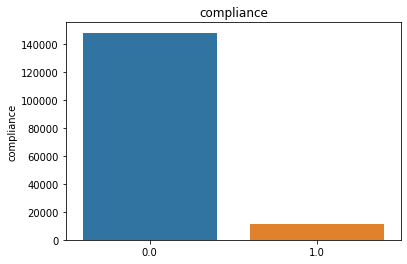

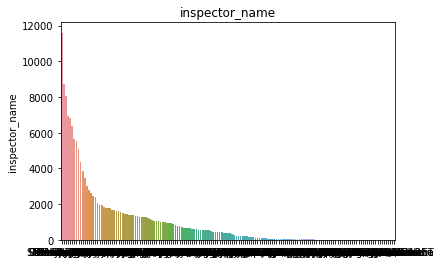

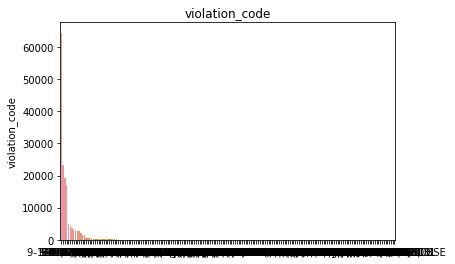

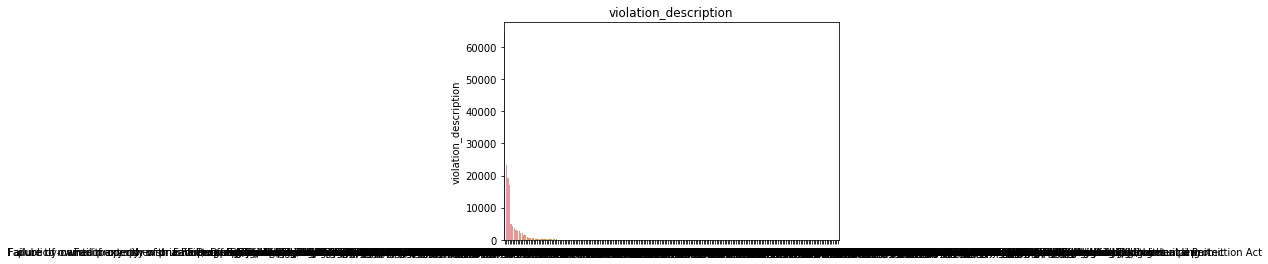

In [29]:
for i in df_train[['compliance','inspector_name','violation_code', 'violation_description']]:
    sns.barplot(df_train[i].value_counts().index,df_train[i].value_counts()).set_title(i)
    #plt.xticks(rotation=90)
    plt.show()

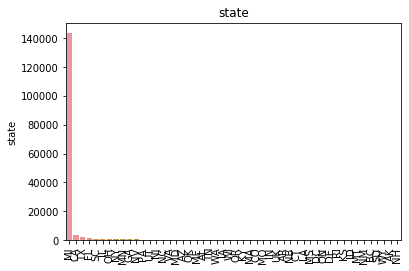

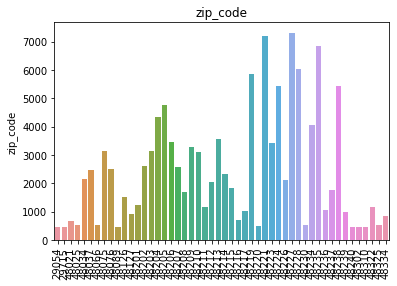

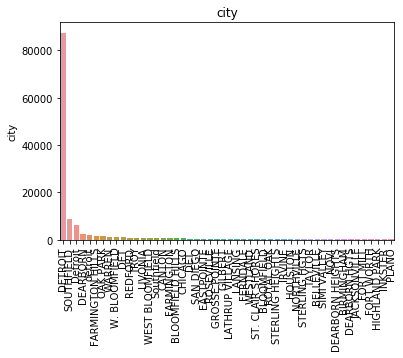

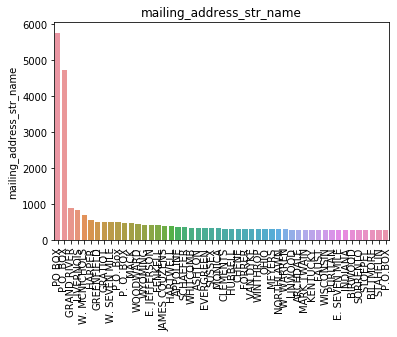

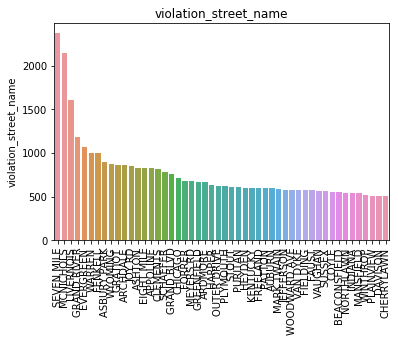

In [30]:
for i in df_train[['state','zip_code','city', 'mailing_address_str_name', 'violation_street_name']]:
    sns.barplot(df_train[i].value_counts().head(50).index,df_train[i].value_counts().head(50)).set_title(i)
    plt.xticks(rotation=90)
    plt.show()

<p><strong>State and city are highly skewed so missing values can be filled with mode.</strong> Zip code is quite randomly distributed and has large number of unique values so I will drop this column. Most street names are P O BOX and I will drop this column due to the large number of unique values.</p>

<h2>Themes to explore</h2>
<ul> <li>Relationship between agency/inspectors and compliance: are there fussy agencies/inspectors which lead to low compliance?</li>
    <li>Does getting a discount lead to more compliance?</li>
    <li>How do late fees affect compliance?</li>
</ul>
<h3>Other things to notice/question:</h3>
<ul> <li>Why are there 59 states?</li>
    <li>Admin and State fees are constants</li>
    <li>What are disposition and violation_description?</li>
    <li>Surprisingly few hearing dates. Any trends with Month/year?</li>
</ul>

First, let's calculate the average compliance as a reference value

In [31]:
avg_compliance = len(df_train[df_train['compliance'] == 1])/len(df_train)

<h3>How does disposition affect compliance?</h3>

In [32]:
pd.pivot_table(df_train, index='compliance', columns='disposition', values= 'ticket_id', aggfunc='count')

disposition,Responsible (Fine Waived) by Deter,Responsible by Admission,Responsible by Default,Responsible by Determination
compliance,,,,
0.0,NaN,9933.0,133055.0,5295.0
1.0,195.0,3768.0,5285.0,2349.0


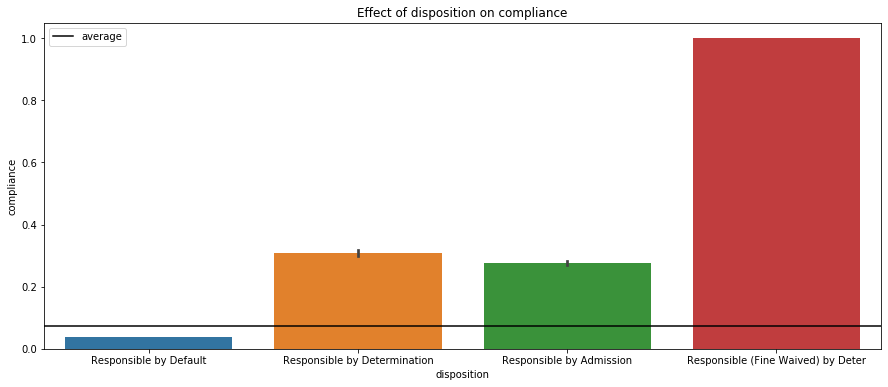

In [33]:
plt.figure(figsize=(15,6))
plt.title('Effect of disposition on compliance')
sns.lineplot(x= [-0.5,4.5], y=[avg_compliance, avg_compliance], color="black", label='average')
sns.barplot(data=df_train, x='disposition', y='compliance')
plt.legend()
plt.show()

<p><strong>I expected people who are responsible by admission to have the second highest compliance but data shows otherwise.</strong></p>
<h3>How does the agency issuing the fine affect compliance?</h3>

In [34]:
pd.pivot_table(df_train, index='compliance', columns='agency_name', values= 'ticket_id', aggfunc='count')

agency_name,"Buildings, Safety Engineering & Env Department",Department of Public Works,Detroit Police Department,Health Department,Neighborhood City Halls
compliance,,,,,
0.0,90040.0,47727.0,3876.0,6639.0,1.0
1.0,5823.0,4718.0,588.0,468.0,NaN


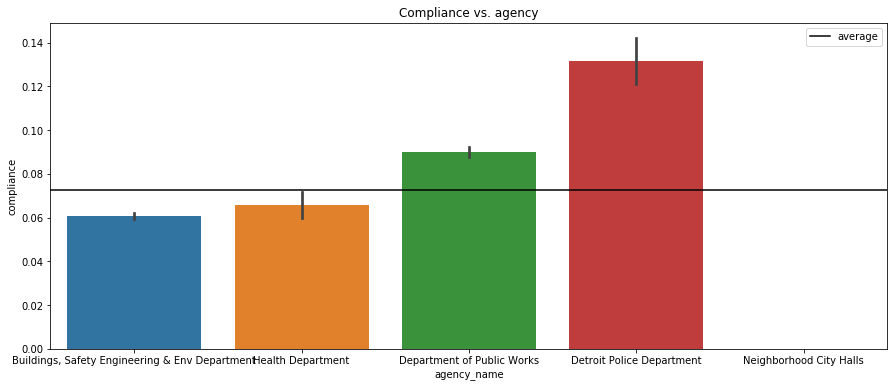

In [35]:
plt.figure(figsize=(15,6))
plt.title('Compliance vs. agency')
sns.lineplot(x= [-0.5,4.5], y=[avg_compliance, avg_compliance], color="black", label='average')
sns.barplot(data=df_train, x='agency_name', y='compliance')
plt.show()

<p><strong>Compliance from Detriot Police Department is clearly higher than all others and nearly double the average.</strong></p>

<h3>Compliance by inspector</h3>

In [36]:
pd.pivot_table(df_train, index='compliance', columns='inspector_name', values= 'ticket_id', aggfunc='count')

inspector_name,"Addison, Michael","Ahmad, Muna I","Anderson, Trevis","Anding, Dwight","BENNETT, MARGARET","Baker, Kenneth","Barela, Ralph","Baumgardner, Robert P","Baxendale, Daniel","Bell, Maydell",...,"Watson, Jerry","Wilcox, Valerie","Wilkins, Rolland W","Williams, Cecila","Williams, Darrin","Williams, Dennis E","Williamson, Lillett","Woodall, Joseph","Zawislak, Norbet","Zizi, Josue"
compliance,,,,,,,,,,,,,,,,,,,,,
0.0,1545.0,531.0,4.0,8.0,1.0,606.0,1216.0,882.0,7.0,1259.0,...,1561.0,19.0,91.0,15.0,394.0,482.0,1383.0,26.0,173.0,4661.0
1.0,122.0,38.0,1.0,NaN,1.0,45.0,101.0,46.0,NaN,89.0,...,113.0,7.0,3.0,1.0,68.0,43.0,156.0,NaN,41.0,399.0


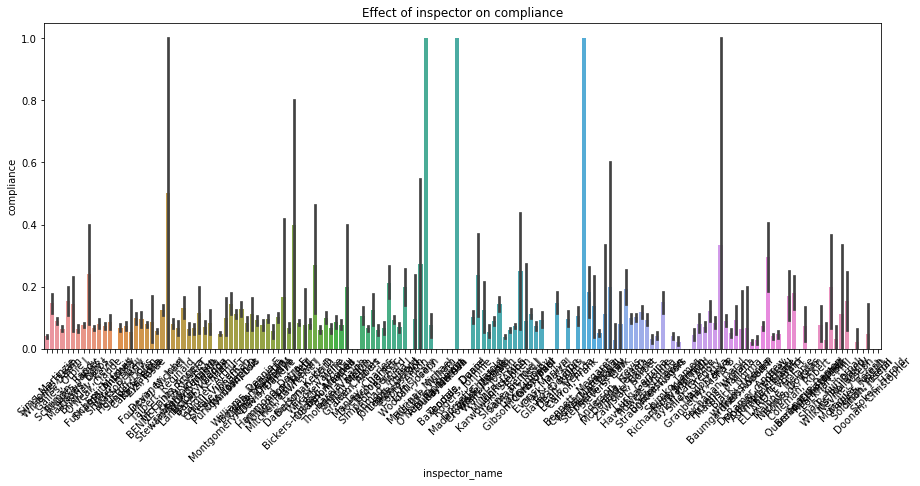

In [37]:
plt.figure(figsize=(15,6))
plt.title('Effect of inspector on compliance')
chart = sns.barplot(data=df_train, x='inspector_name', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p><strong>Perhaps we could do some feature engineering with inspector_name</strong></p>

<h3>Let's look at the effect of discounts on compliance</h3>

In [38]:
df_train['discount_amount'].unique()

array([  0.,  25.,  30.,  10.,  50.,  20.,   5.,   3., 100., 250., 350.,
        13.,  40.])

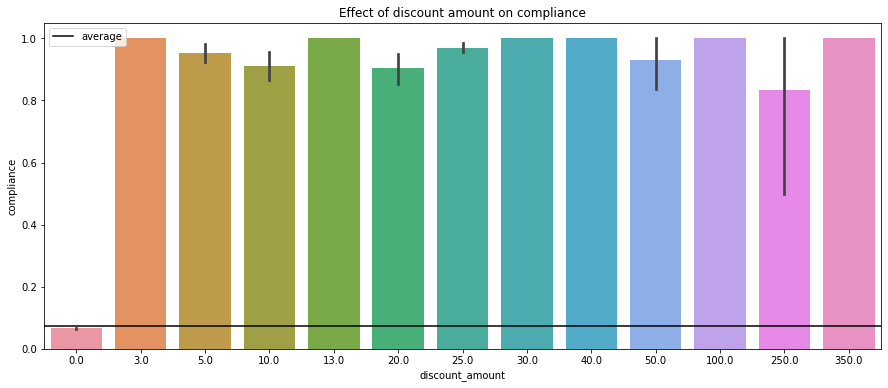

In [39]:
plt.figure(figsize=(15,6))
plt.title('Effect of discount amount on compliance')
sns.lineplot(x= [-0.5,12.5], y=[avg_compliance, avg_compliance], color="black", label='average')
sns.barplot(data=df_train, x='discount_amount', y='compliance')
plt.show()

<p><strong>Clearly getting a discount seems to significantly increase compliance (even if it's just \$3). Interesting that a \$250 discount is not motivation enough for some people.</strong> Let' see how often discount's are given</p> 

In [40]:
df_train.groupby("discount_amount")['ticket_id'].count()

discount_amount
0.0      158700
3.0          19
5.0         167
10.0        155
13.0          1
20.0        135
25.0        605
30.0         17
40.0          1
50.0         43
100.0        16
250.0         6
350.0        15
Name: ticket_id, dtype: int64

In [41]:
100*(len(df_train[df_train['discount_amount']> 0.0])/len(df_train))

0.7380535401551164

<p><strong> Discounts are only given 0.7% of the time so it's hard to draw solid conlusions from this. Perhaps the city could look into giving more discounts in order to increase compliance?</strong></p>

<h3>Does getting a late fee make people more likely to comply?</h3>

In [42]:
pd.pivot_table(df_train, index='compliance', columns='late_fee', values= 'ticket_id', aggfunc='count')

late_fee,0.0,0.1,2.5,5.0,9.5,10.0,12.5,15.0,16.0,17.0,...,175.0,200.0,250.0,269.5,300.0,350.0,500.0,700.0,800.0,1000.0
compliance,,,,,,,,,,,,,,,,,,,,,
0.0,9856.0,NaN,1191.0,16642.0,2.0,11645.0,701.0,1.0,2.0,1.0,...,NaN,14.0,1477.0,NaN,4.0,3736.0,85.0,13.0,1.0,194.0
1.0,5602.0,1.0,32.0,1013.0,NaN,871.0,22.0,NaN,NaN,NaN,...,2.0,NaN,29.0,1.0,NaN,49.0,NaN,NaN,NaN,1.0


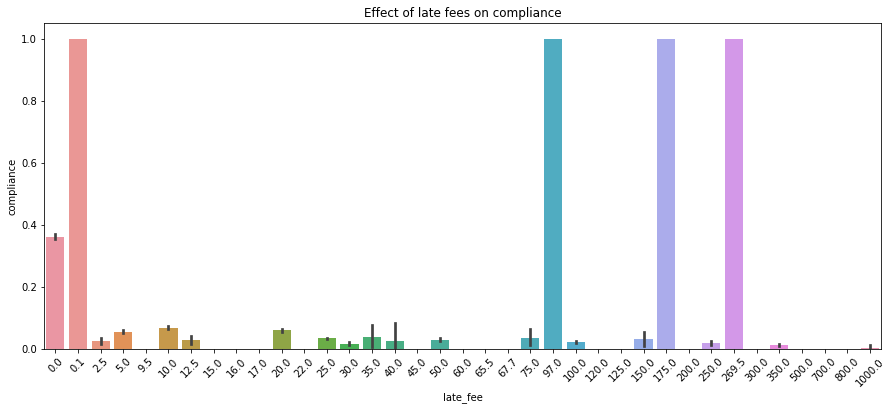

In [43]:
plt.figure(figsize=(15,6))
plt.title('Effect of late fees on compliance')
chart = sns.barplot(data=df_train, x='late_fee', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p>I'm not sure what conclusions to draw from this seemingly random behaviour</p>

<h3>Compliance vs. state</h3>

In [44]:
df_train['state'].unique()

array(['IL', 'MI', 'CA', 'NY', 'MN', 'NV', 'PA', 'LA', 'MD', 'FL', 'ME',
       'KY', 'TX', 'AZ', 'TN', 'OH', 'GA', 'IN', 'MS', 'NJ', 'WA', 'WI',
       'UT', 'VA', 'SC', 'MO', 'AL', 'DC', 'CT', 'AR', 'OK', 'MA', 'CO',
       'UK', 'NC', 'AK', 'RI', 'NM', 'VT', 'NB', 'MT', 'IA', 'ID', 'OR',
       'DE', 'PR', 'NH', 'VI', 'KS', 'SD', 'QC', 'ON', 'HI', 'QL', nan,
       'WY', 'WV', 'ND', 'BC', 'BL'], dtype=object)

UK and 'nan' are not states

In [45]:
pd.pivot_table(df_train, index='compliance', columns='state', values= 'ticket_id', aggfunc='count')

state,AK,AL,AR,AZ,BC,BL,CA,CO,CT,DC,...,TX,UK,UT,VA,VI,VT,WA,WI,WV,WY
compliance,,,,,,,,,,,,,,,,,,,,,
0.0,10.0,132.0,54.0,236.0,16.0,1.0,3646.0,81.0,46.0,41.0,...,1862.0,59.0,306.0,269.0,1.0,6.0,124.0,104.0,5.0,11.0
1.0,1.0,6.0,2.0,9.0,NaN,NaN,182.0,16.0,3.0,3.0,...,90.0,3.0,23.0,17.0,NaN,NaN,11.0,8.0,NaN,1.0


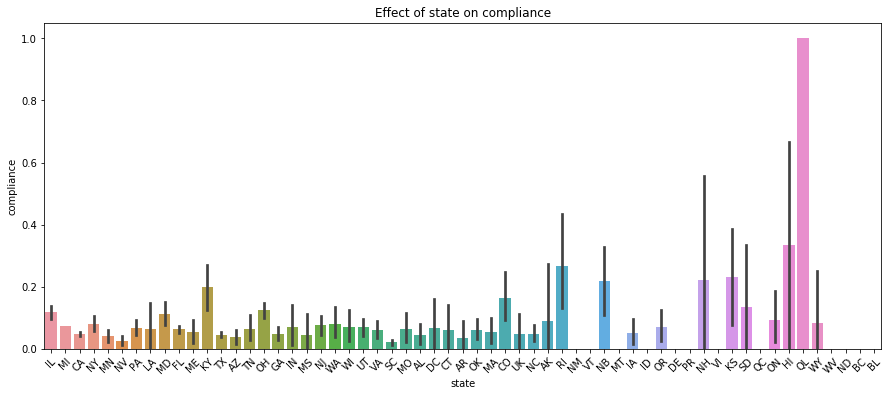

In [46]:
plt.figure(figsize=(15,6))
plt.title('Effect of state on compliance')
chart = sns.barplot(data=df_train, x='state', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

'QL' has perfect complaince. Let's investigate

In [47]:
df_train[df_train['state'] == 'QL']

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance,train_test
177864,209821,Department of Public Works,"Havard, Jacqueline","ANDERTON, ANDREW",8897.0,EVERGREEN,NaN,238.0,ROBINA TOWN CENTER,QUEENSLAND,...,100.0,20.0,10.0,0.0,0.0,0.0,130.0,NaN,1.0,1
247141,281901,Department of Public Works,"Zizi, Josue","YU, JOYCE",19921.0,INDIANA,NaN,16.0,"LANE 70,PING DING RD DAMSHUI","TARPEIHSIENG TAIWAN R,QC",...,50.0,20.0,10.0,0.0,0.0,0.0,80.0,NaN,1.0,1


Only 2 entries so this is an outlier. Let's plot without QL

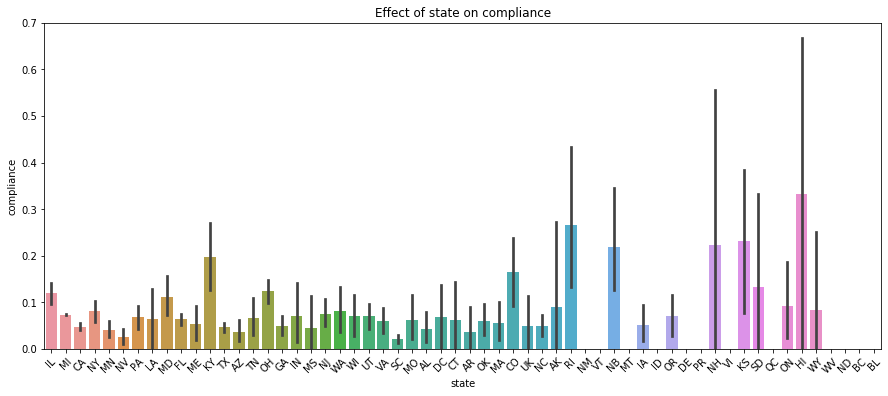

In [48]:
plt.figure(figsize=(15,6))
plt.title('Effect of state on compliance')
chart = sns.barplot(data=df_train[df_train['state'] != 'QL'], x='state', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

No clear trends to notice. Besides, MI (Michigan) is by far the most frequent state.

<h3>Violation description and violation codes</h3>

In [49]:
df_train.groupby('violation_code')['violation_description'].nunique().sort_values(ascending=False).head(10)

violation_code
61-5-21                 8
61-5-18                 3
19420901                2
22-2-21(b)              2
22-2-61                 2
22-2-44                 2
9-1-43(a) - (Structu    2
9-1-43(a) - (Stories    2
9-1-43(a) - (Dwellin    2
22-2-83(b)              2
Name: violation_description, dtype: int64

In [50]:
df_train[df_train['violation_code'] == '61-5-21']['violation_description'].unique()

array(['Failed to comply with other land use or procedural requirements - Unlawful Sign, Banner or antenna',
       'Failed to comply with other land use or procedural requirements - FAILURE TO COMPLY WITH PROCEDURAL OR OTHER REQUIREMENTS',
       'Failed to comply with other land use or procedural requirements - Vehicle other than operable recreational equipment or operable privat',
       'Failed to comply with other land use or procedural requirements - Inoperable vehicle(Non-RESIDENTIAL)',
       'Failed to comply with other land use or procedural requirements - OTHER NON-COMPLIANCE WITH LAND USE REQUIREMENTS',
       'Failed to comply with other land use or procedural requirements - Other unlawful storage(RESIDENTIAL)',
       'Failed to comply with other land use or procedural requirements - Inoperable private passenger vehicle(RESIDENTIAL)',
       'Failed to comply with other land use or procedural requirements - Other unlawful storage(Non-RESIDENTIAL)'],
      dtype=object)

<p><font color='blue'>I think we can drop violation description as violation code appears to provide the same information.</font></p>

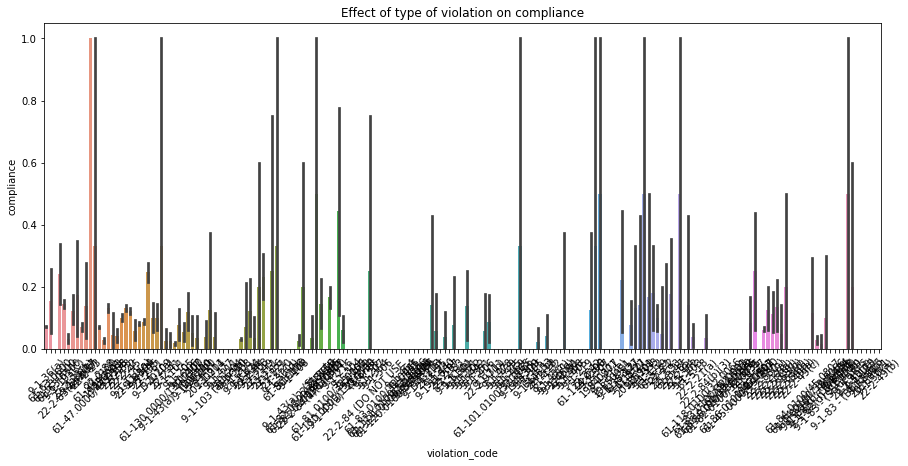

In [51]:
plt.figure(figsize=(15,6))
plt.title('Effect of type of violation on compliance')
chart = sns.barplot(data=df_train, x='violation_code', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Data looks messy and could benefit from some feature engineering

<h3>Distributions for all numeric variables</h3>

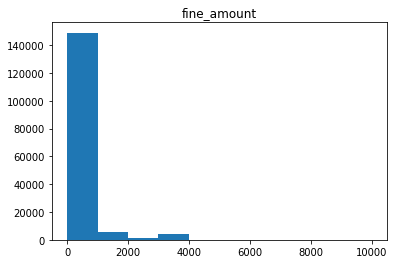

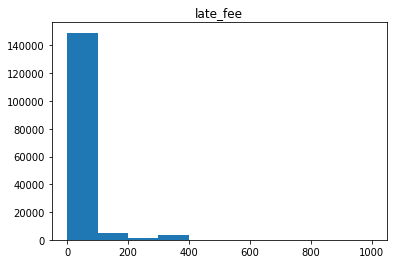

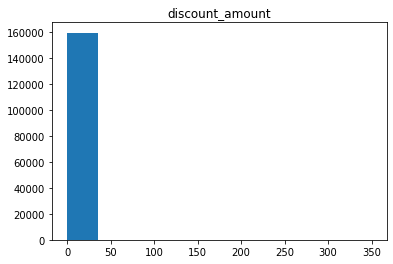

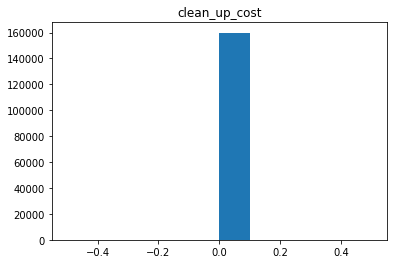

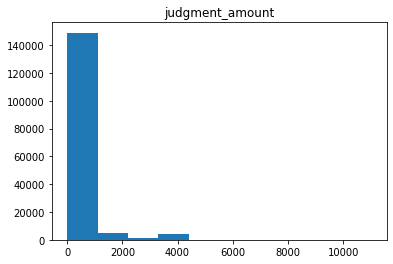

In [52]:
for i in df_numerical.columns:
    plt.hist(df_numerical[i])
    plt.title(i)
    plt.show()

<p><font color='blue'>Numerical data clearly needs to be normalised</font></p>

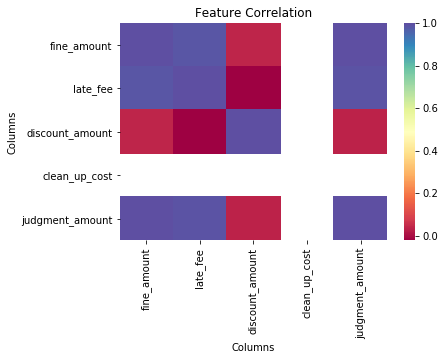

In [53]:
sns.heatmap(df_numerical.corr(), cmap='Spectral').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns');

<p><strong>Due to strong correlation I cold drop some of these fees. However this is more critical for regression problems.</strong><p>

In [54]:
df_train['clean_up_cost'].unique()

array([0.])

In [55]:
df_test['clean_up_cost'].nunique()

298

<p><strong>No clean up cost in training data so will drop this column</strong></p>

<h3>Effect of hearing and ticket issue date</h3>
<p>First convert to datetime so we can get month and year</p>

In [56]:
all_data['ticket_issued_date'] = pd.to_datetime(all_data['ticket_issued_date'])
all_data['hearing_date'] = pd.to_datetime(all_data['hearing_date'])

In [57]:
df_train['ticket_issued_date'] = pd.to_datetime(df_train['ticket_issued_date'])
df_train['hearing_date'] = pd.to_datetime(df_train['hearing_date'])

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Create columns for month and year

In [58]:
all_data['ticket_issued_month'] = pd.DatetimeIndex(all_data['ticket_issued_date']).month
all_data['ticket_issued_yr'] = pd.DatetimeIndex(all_data['ticket_issued_date']).year

In [59]:
df_train['ticket_issued_month'] = pd.DatetimeIndex(df_train['ticket_issued_date']).month
df_train['ticket_issued_yr'] = pd.DatetimeIndex(df_train['ticket_issued_date']).year

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Convert months to string

In [60]:
import calendar
all_data['ticket_issued_month'] = all_data['ticket_issued_month'].apply(lambda x: calendar.month_abbr[x])
df_train['ticket_issued_month_s'] = df_train['ticket_issued_month'].apply(lambda x: calendar.month_abbr[x])

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h3>How does compliance vary with month of fine?<h3>

In [61]:
pd.pivot_table(df_train, index='compliance', columns='ticket_issued_month_s', values= 'ticket_id', aggfunc='count')

ticket_issued_month_s,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
compliance,,,,,,,,,,,,
0.0,11657,14110,7498,12719,11173,12530,13339,13706,12519,9652,14579,14801
1.0,983,835,657,1276,1092,830,962,1442,1047,669,889,915


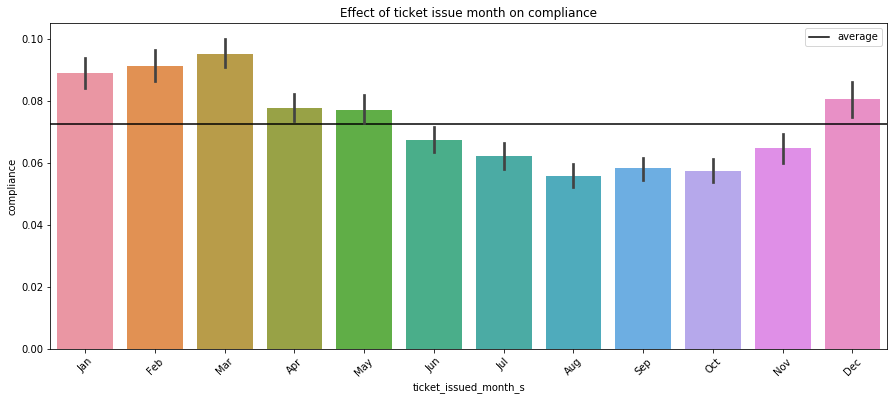

In [62]:
plt.figure(figsize=(15,6))
plt.title('Effect of ticket issue month on compliance')
sns.lineplot(x= [-0.5,11.5], y=[avg_compliance, avg_compliance], color="black", label='average')
chart = sns.barplot(data=df_train.sort_values(by='ticket_issued_month'), x='ticket_issued_month_s', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p><strong>It appears compliance increases between Autumn-Spring (Sept-March) and then slowly reduces from Spring-end of Summer.</strong></p>

<h3>How has complianced changed over the years?</h3>

In [63]:
pd.pivot_table(df_train, index='compliance', columns='ticket_issued_yr', values= 'ticket_id', aggfunc='count')

ticket_issued_yr,1988,2004,2005,2006,2007,2008,2009,2010,2011
compliance,,,,,,,,,
0.0,NaN,12.0,23667.0,26130.0,25565.0,27390.0,20687.0,15156.0,9676.0
1.0,1.0,3.0,2162.0,2142.0,2024.0,1892.0,1656.0,794.0,923.0


1988 has only 1 entry and  2004 is also a relatively small data set (only 15 entries). Let's plot from 2005 onwards.

In [64]:
df_train_yr = df_train[df_train['ticket_issued_yr'] > 2004]

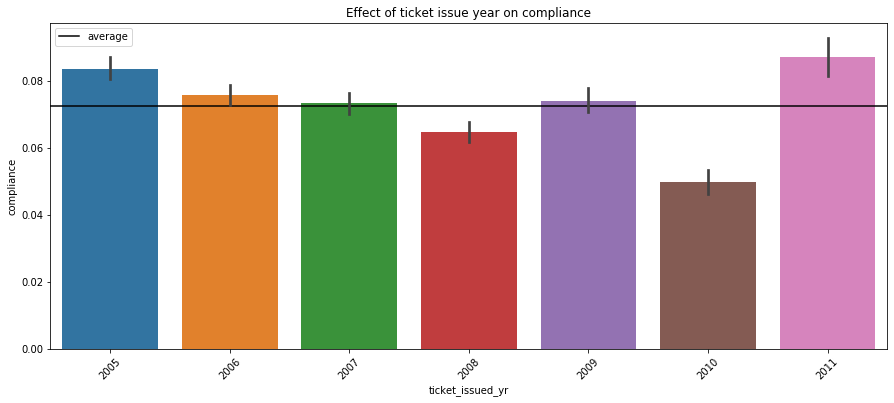

In [65]:
plt.figure(figsize=(15,6))
plt.title('Effect of ticket issue year on compliance')
sns.lineplot(x= [-0.5,6.5], y=[avg_compliance, avg_compliance], color="black", label='average')
chart = sns.barplot(data=df_train_yr, x='ticket_issued_yr', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p>Compliance seemed to be dropping from year to year but last 3 years show different behaviour. Not much insight to gain from this.</p>

<h3>Effect of hearing date on compliance</h3>
<p>First drop missing values</p>

In [66]:
df_train_hearing = df_train.dropna(subset=['hearing_date'])
df_train_hearing['hearing_date_month'] = pd.DatetimeIndex(df_train_hearing['hearing_date']).month
df_train_hearing['hearing_date_yr'] = pd.DatetimeIndex(df_train_hearing['hearing_date']).year
df_train_hearing['hearing_date_month_s'] = df_train_hearing['hearing_date_month'].apply(lambda x: calendar.month_abbr[x])

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set o

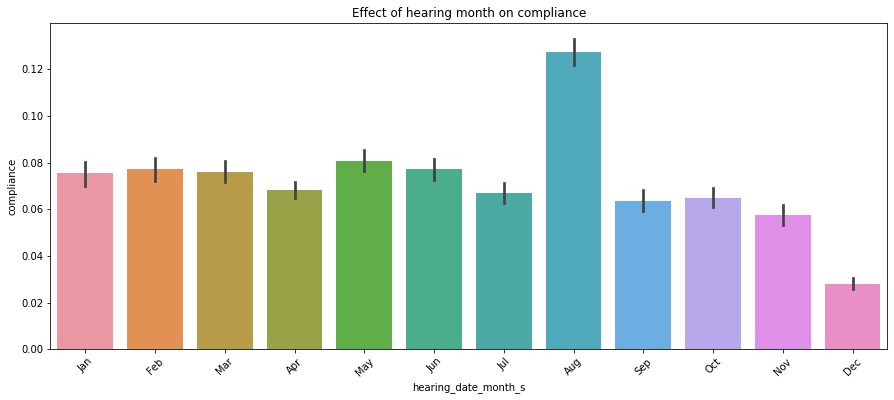

In [67]:
plt.figure(figsize=(15,6))
plt.title('Effect of hearing month on compliance')
chart = sns.barplot(data=df_train_hearing.sort_values(by='hearing_date_month'), x='hearing_date_month_s', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p>Quite a uniform distribution apart from Aug and Dec</p>

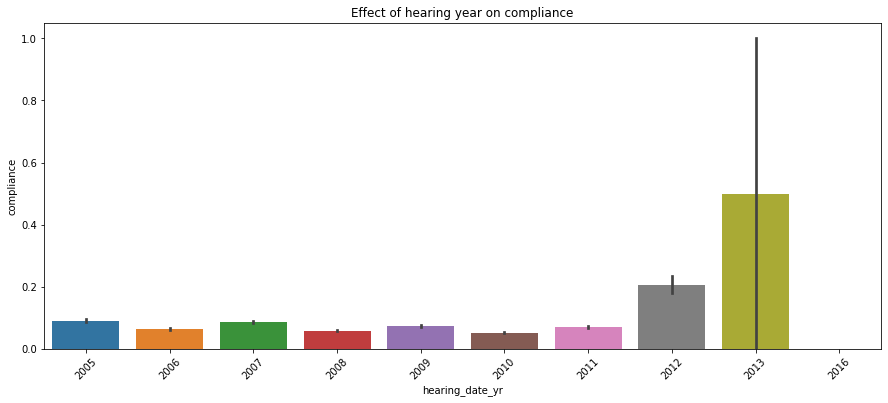

In [68]:
plt.figure(figsize=(15,6))
plt.title('Effect of hearing year on compliance')
chart = sns.barplot(data=df_train_hearing, x='hearing_date_yr', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p>Compliance seems to be increasing in the last few years.</p>

<h2>Summary of EDA</h2>
<ul><li>Compliance is quite low in general but some agencies (Police department) have higher compliance rates.</li>
    <li>Surprisingly, Responsible by admission has low compliance rate.</li>
    <li>There appears to be a seasonal effect of ticket issuing on compliance as it increases from autumn to spring and decreases from spring to autumn.</li>
    <li>Getting any form of discount increases compliance</li>
</ul>

We still need to fill in missing values for the following columns:

In [69]:
all_data.isnull().sum().sort_values(ascending = False)

compliance                    61001
mailing_address_str_number     3572
hearing_date                   2424
state                           415
mailing_address_str_name          6
zip_code                          4
city                              1
ticket_issued_yr                  0
violation_code                    0
agency_name                       0
inspector_name                    0
violation_street_number           0
violation_street_name             0
country                           0
ticket_issued_date                0
violation_description             0
ticket_issued_month               0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
train_test                        0
address                           0
lat                         

<ol><li>mailing_address_str_number and mailing_address_str_name both have a high number of unique values so it might not be wise to keep these. However, these may be useful for feature engineering. We could create a new feature to check if violation_street_name and mailing_address_str_name are the same. There might be something related to violations at personal residence.</li>
    <li>Analysis of hearing date month and year wasn't very helpful. Let's try and use the typical time difference between ticket issue date and hearing date to fill this.</li>
    <li>State and city have relatively few missing values and can be filled with mode. As the data is mostly from Detriot, Michigan, I will change this to a flag for Detriot or not.</li>
</ol>

Drop ticket_id, admin_fee, state_fee, late fee, 'fine_amount', clean_up_cost, mailing_address_str_number, zip_code, violation_street_number.

In [70]:
to_drop = ['admin_fee', 'state_fee', 'late_fee', 'fine_amount', 'clean_up_cost', 'mailing_address_str_number', 'zip_code', 'violation_street_number']

In [71]:
all_data.drop(labels=to_drop, axis=1,inplace=True)
df_train.drop(labels=to_drop, axis=1,inplace=True)

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<h1>Part III: Feature Engineering</h1>
<p>Due to the large number of categorical columns in the data + unique values for each category, let's create some new features so that training is easier. Some ideas from data exploration:</p>
<ul>
    <li>state: convert to Michigan or not</li>
    <li>city: convert to Detriot or not</li>
    <li>discount_amount: convert to discount given or not</li>
    <li>violation code: is there a pattern based on numbering?</li>
    <li>inspector_name: can we create categories based on number of tickets issued?</li>
    <li>address: is there a pattern for compliance if violation address is same as mailing address?</li>
    <li>dates: is there a pattern related to the number of days between the ticket issue and hearing dates?</li>
</ul>

First fill in missing state and city values with detroit, MI

In [72]:
all_data['state'].fillna(all_data['state'].mode()[0], inplace=True)
all_data['city'].fillna(all_data['city'].mode()[0], inplace=True)

Now create flags

In [73]:
all_data['michigan_flag'] = all_data.apply(lambda x: x['state'] == 'MI', axis=1).astype(int)
all_data['detroit_flag'] = all_data.apply(lambda x: x['city'].lower() == 'detroit', axis=1).astype(int)

In [74]:
df_train['country'].unique()

array(['USA', 'Cana', 'Aust', 'Egyp', 'Germ'], dtype=object)

In [75]:
df_test['country'].unique()

array(['USA'], dtype=object)

In [76]:
df_train.groupby(by='country')['ticket_id'].count()

country
Aust         2
Cana         6
Egyp         2
Germ         1
USA     159869
Name: ticket_id, dtype: int64

drop non-US countries since test data doesn't have any

In [77]:
all_data.drop(all_data[all_data['country'] != 'USA'].index, inplace=True)

Create flag for discount given or not

In [78]:
all_data['discount_given'] = all_data.apply(lambda x: x['discount_amount']> 0., axis=1).astype(int)

Explore violation codes

In [79]:
all_data['violation_code'].unique()

array(['9-1-36(a)', '61-63.0600', '61-63.0500', '61-63.0100',
       '9-1-103(C)', '22-2-83(a)(b)(c)', '22-2-21(b)', '9-1-36(c)',
       '22-2-17', '22-2-23', '61-47.0000/47.0108', '61-90.0100',
       '22-2-88', '19450901', '22-2-43', '9-1-355', '22-2-83', '22-2-22',
       '22-2-45', '9-1-110(a)', '22-2-88(a)', '9-1-104', '9-1-105',
       '22-2-61', '9-1-201(a)', '9-1-209', '61-130.0000/130.0400',
       '22-2-41', '9-1-101', '9-1-43(a) - (Dwellin', '9-1-205', '9-1-206',
       '9-1-107', '9-1-201(b)', '9-1-210', '9-1-220', '20130901',
       '9-1-214', '9-1-103 (a) or (b)', '9-1-477', '9-1-211', '9-1-204',
       '9-1-310', '9-1-208', '9-1-81(a)', '9-1-476', '22-2-44', '9-1-303',
       '22-2-49', '9-1-111', '22-2-16', '9-1-221', '22-2-20', '9-1-36(d)',
       '61-80.0100', '9-1-106', '9-1-108', '9-1-43(a) - (Structu',
       '61-82.0100/32.0066', '61-81.0100/45.0807', '22-2-84(a)(1)(2)(4)',
       '22-2-87(a)', '22-2-56', '19830901', '61-81.0100/32.0066',
       '61-130.0000/130.0

There appears to be a pattern related to '9-1', '61-', '22-'. Let's investigate further

In [80]:
def code_groups(code):
    groups = {'9-1': 'nines', '61-': 'sixes', '22-': 'twos'}
    if code in groups.keys():
        return groups[code]
    else:
        return 'other'

In [81]:
all_data['codes'] = all_data['violation_code'].map(lambda x: code_groups(x[:3]))

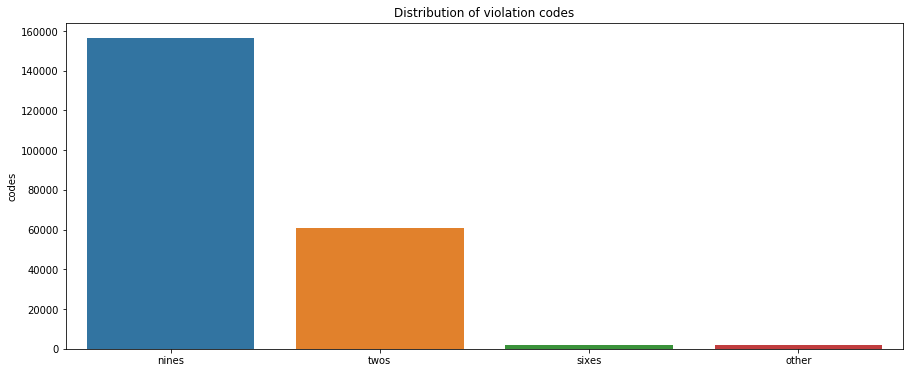

In [82]:
plt.figure(figsize=(15,6))
sns.barplot(all_data['codes'].value_counts().index,all_data['codes'].value_counts()).set_title('Distribution of violation codes')
plt.show()

In [83]:
pd.pivot_table(all_data, index='compliance', columns='codes', values= 'ticket_id', aggfunc='count')

codes,nines,other,sixes,twos
compliance,,,,
0.0,111696,1688,1058,33832
1.0,8231,55,152,3157


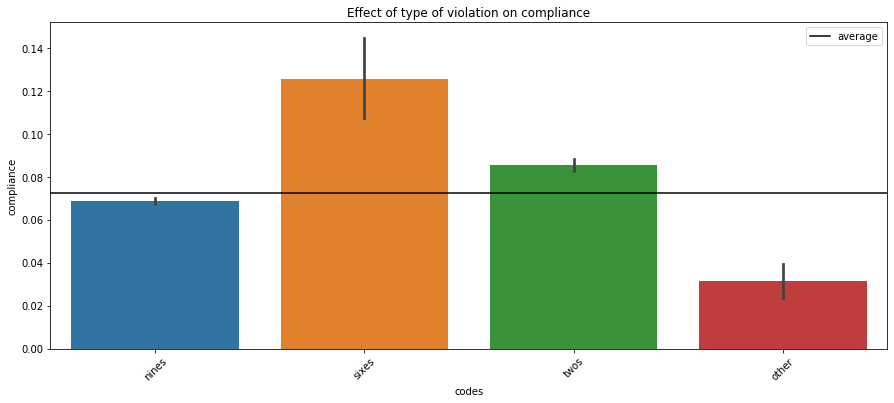

In [84]:
plt.figure(figsize=(15,6))
plt.title('Effect of type of violation on compliance')
sns.lineplot(x= [-0.5,4.5], y=[avg_compliance, avg_compliance], color="black", label='average')
chart = sns.barplot(data=all_data, x='codes', y='compliance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

<p><strong>We can see that violation codes beginning with 61- have the highest compliance despite having a relatively low count. We can also see 22- codes have above average compliance.</strong></p>

Exploring inspector names

In [85]:
df_train['inspector_name']= df_train['inspector_name'].apply(lambda x: x.lower())
df_test['inspector_name']= df_test['inspector_name'].apply(lambda x: x.lower())
all_data['inspector_name']= all_data['inspector_name'].apply(lambda x: x.lower())

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
all_data['inspector_name'].nunique()

216

In [87]:
train_names = list(df_train['inspector_name'].unique())

In [88]:
len(train_names)

158

In [89]:
test_names = list(df_test['inspector_name'].unique())

In [90]:
len(test_names)

116

<p><strong>There are 216 unique inspector names with different names in training and test data. I will drop this column. Also because for future predictions, the names of inspectors will be different.</strong></p>

Let's create a column for when the violation address and mailing address are the same.

In [91]:
all_data['mailing_address_str_name'] = all_data['mailing_address_str_name'].apply(lambda x: str(x).lower())
all_data['violation_street_name'] = all_data['violation_street_name'].apply(lambda x: str(x).lower())

In [92]:
all_data['violation_at_home'] = all_data.apply(lambda x: x['violation_street_name'] in x['mailing_address_str_name'], axis=1).astype(int)

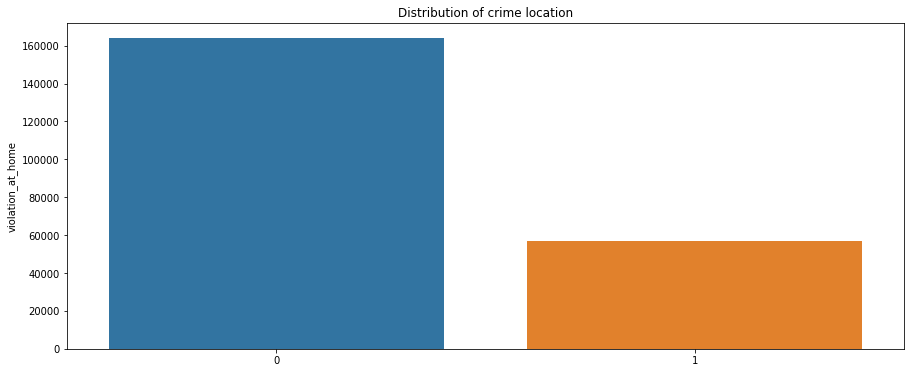

In [93]:
plt.figure(figsize=(15,6))
sns.barplot(all_data['violation_at_home'].value_counts().index,all_data['violation_at_home'].value_counts()).set_title('Distribution of crime location')
plt.show()

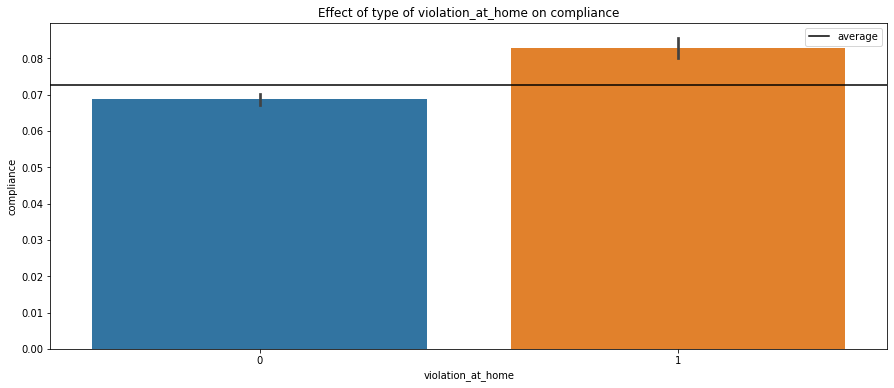

In [94]:
plt.figure(figsize=(15,6))
plt.title('Effect of type of violation_at_home on compliance')
sns.lineplot(x= [-0.5,1.5], y=[avg_compliance, avg_compliance], color="black", label='average')
chart = sns.barplot(data=all_data, x='violation_at_home', y='compliance')
chart.set_xticklabels(chart.get_xticklabels())
plt.show()

The compliance for crime_at home is higher than the average so this might be a useful feature.

In [95]:
all_data['time_difference'] = (all_data['hearing_date']-all_data['ticket_issued_date']).dt.days

In [96]:
all_data['time_difference'].describe()

count    218446.000000
mean         62.824542
std          57.338656
min        -337.000000
25%          27.000000
50%          44.000000
75%          83.000000
max        7933.000000
Name: time_difference, dtype: float64

<p><font color='red'>The time difference should never be negative, this suggests that the time data is not reliable.</font> Let's plot differences less than one year.</p>

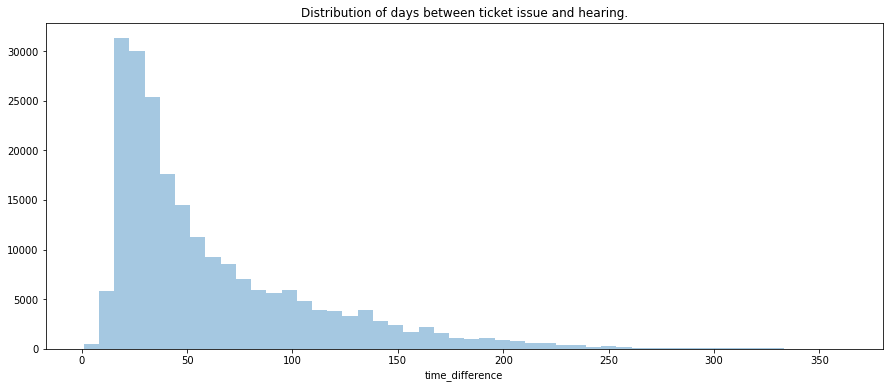

In [97]:
plt.figure(figsize=(15,6))
sns.distplot(a=all_data[(all_data['time_difference'] > 0) & (all_data['time_difference'] < 365)]['time_difference'], kde=False).set_title('Distribution of days between ticket issue and hearing.')
plt.show()

I will drop all data related to hearing date as this is more likely to be erroneous (ticket_issue_date has no null values).

In [98]:
all_data.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violation_street_name',
       'mailing_address_str_name', 'city', 'state', 'country',
       'ticket_issued_date', 'hearing_date', 'violation_code',
       'violation_description', 'disposition', 'discount_amount',
       'judgment_amount', 'compliance', 'train_test', 'address', 'lat', 'lon',
       'ticket_issued_month', 'ticket_issued_yr', 'michigan_flag',
       'detroit_flag', 'discount_given', 'codes', 'violation_at_home',
       'time_difference'],
      dtype='object')

Drop 'ticket_id', 'inspector_name', 'violation_street_name', 'mailing_address_str_name', 'city', 'state', 'country',  'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'discount_amount', 'address', 'time_difference'    

In [99]:
to_drop2 = ['ticket_id', 'inspector_name', 'violation_street_name', 'mailing_address_str_name', 'city', 'state', 'country', 'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'discount_amount', 'address', 'time_difference']
final_data = all_data.drop(labels=to_drop2, axis=1)

In [100]:
final_data.columns

Index(['agency_name', 'disposition', 'judgment_amount', 'compliance',
       'train_test', 'lat', 'lon', 'ticket_issued_month', 'ticket_issued_yr',
       'michigan_flag', 'detroit_flag', 'discount_given', 'codes',
       'violation_at_home'],
      dtype='object')

In [101]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220870 entries, 0 to 220880
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   agency_name          220870 non-null  object 
 1   disposition          220870 non-null  object 
 2   judgment_amount      220870 non-null  float64
 3   compliance           159869 non-null  float64
 4   train_test           220870 non-null  int64  
 5   lat                  220870 non-null  float64
 6   lon                  220870 non-null  float64
 7   ticket_issued_month  220870 non-null  object 
 8   ticket_issued_yr     220870 non-null  int64  
 9   michigan_flag        220870 non-null  int64  
 10  detroit_flag         220870 non-null  int64  
 11  discount_given       220870 non-null  int64  
 12  codes                220870 non-null  object 
 13  violation_at_home    220870 non-null  int64  
dtypes: float64(4), int64(6), object(4)
memory usage: 35.3+ MB


<h2>Data pre-processing</h2>

In [102]:
final_dummies = pd.get_dummies(final_data)

In [103]:
final_dummies.columns

Index(['judgment_amount', 'compliance', 'train_test', 'lat', 'lon',
       'ticket_issued_yr', 'michigan_flag', 'detroit_flag', 'discount_given',
       'violation_at_home',
       'agency_name_Buildings, Safety Engineering & Env Department',
       'agency_name_Department of Public Works',
       'agency_name_Detroit Police Department',
       'agency_name_Health Department', 'agency_name_Neighborhood City Halls',
       'disposition_Responsible (Fine Waived) by Admis',
       'disposition_Responsible (Fine Waived) by Deter',
       'disposition_Responsible - Compl/Adj by Default',
       'disposition_Responsible - Compl/Adj by Determi',
       'disposition_Responsible by Admission',
       'disposition_Responsible by Default',
       'disposition_Responsible by Determination',
       'disposition_Responsible by Dismissal', 'ticket_issued_month_Apr',
       'ticket_issued_month_Aug', 'ticket_issued_month_Dec',
       'ticket_issued_month_Feb', 'ticket_issued_month_Jan',
       'ticket

In [104]:
final_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220870 entries, 0 to 220880
Data columns (total 39 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   judgment_amount                                             220870 non-null  float64
 1   compliance                                                  159869 non-null  float64
 2   train_test                                                  220870 non-null  int64  
 3   lat                                                         220870 non-null  float64
 4   lon                                                         220870 non-null  float64
 5   ticket_issued_yr                                            220870 non-null  int64  
 6   michigan_flag                                               220870 non-null  int64  
 7   detroit_flag                                                220870 non-nul

In [105]:
numeric = ['judgment_amount', 'lat', 'lon', 'ticket_issued_yr']

In [106]:
training_data = final_dummies[final_dummies.train_test == 1].drop(['train_test'], axis =1)
test_data = final_dummies[final_dummies.train_test == 0].drop(['train_test', 'compliance'], axis =1)

In [107]:
len(training_data.columns)

38

In [108]:
len(test_data.columns)

37

In [109]:
y = training_data['compliance']
X = training_data.drop(['compliance'], axis=1)

In [110]:
from sklearn.model_selection import train_test_split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h1>Part IV: Default models</h1>

In [112]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[numeric] = sc.fit_transform(X_train[numeric])
X_test[numeric] = sc.transform(X_test[numeric])

/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value

<h3>Naive Bayes</h3>

In [113]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_nb = gnb.fit(X_train, y_train).predict_proba(X_test)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_nb[:,1])
roc_auc_nb = auc(fpr_nb, tpr_nb)
print('ROC curve area = %0.4f'%roc_auc_nb)

ROC curve area = 0.7569


<h3>Logistic Regression</h3>

In [114]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
y_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print('ROC curve area = %0.4f'%roc_auc_lr)

ROC curve area = 0.7775


/Users/dareimamlawal/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<h3>KNN</h3>

In [115]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
y_knn = knn.fit(X_train, y_train).predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_knn[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
print('ROC curve area = %0.4f'%roc_auc_knn)

ROC curve area = 0.7324


<h3>Random Forest</h3>

In [116]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier( criterion = 'entropy', random_state = 0)
y_rf = classifier.fit(X_train, y_train).predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
print('ROC curve area = %0.4f'%roc_auc_rf)

ROC curve area = 0.8196


<h3>Support Vector Classifier: Linear</h3>

In [117]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
y_svc_linear = classifier.fit(X_train, y_train).decision_function(X_test)
fpr_svc_linear, tpr_svc_linear, _ = roc_curve(y_test, y_svc_linear)
roc_auc_svcl = auc(fpr_svc_linear, tpr_svc_linear)
print('ROC curve area = %0.4f'%roc_auc_svcl)

ROC curve area = 0.5631


<h3>Support Vector Classifier: rbf</h3>

In [118]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
y_svc_rbf = classifier.fit(X_train, y_train).decision_function(X_test)
fpr_svc_rbf, tpr_svc_rbf, _ = roc_curve(y_test, y_svc_rbf)
roc_auc_svcr = auc(fpr_svc_rbf, tpr_svc_rbf)
print('ROC curve area = %0.4f'%roc_auc_svcr)

ROC curve area = 0.6594


<h3>ROC curves</h3>

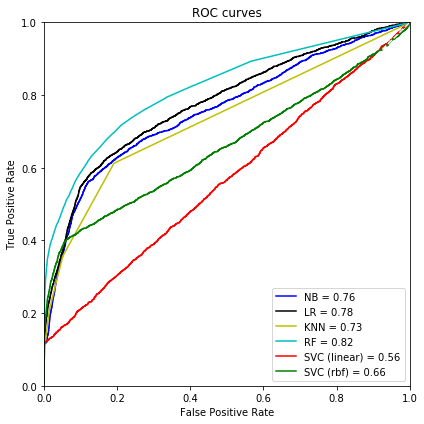

In [120]:
fig = plt.figure(figsize=(6, 6))
plt.title('ROC curves')
plt.plot(fpr_nb, tpr_nb, 'b', label = 'NB = %0.2f' % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'k', label = 'LR = %0.2f' % roc_auc_lr)
plt.plot(fpr_knn, tpr_knn, 'y', label = 'KNN = %0.2f' % roc_auc_knn)
plt.plot(fpr_rf, tpr_rf, 'c', label = 'RF = %0.2f' % roc_auc_rf)
plt.plot(fpr_svc_linear, tpr_svc_linear, 'r', label = 'SVC (linear) = %0.2f' % roc_auc_svcl)
plt.plot(fpr_svc_rbf, tpr_svc_rbf, 'g', label = 'SVC (rbf) = %0.2f' % roc_auc_svcr)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'w--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

<h1>Part V: Model Tuning + Boosting</h1>
<p>Perform Grid search on only Logistic Regression and Random Forest. KNN and SVC train very slowly.</p>
<p>Compare boosting methods.</p>

In [123]:
from sklearn.model_selection import GridSearchCV 

In [124]:
lr = LogisticRegression()
param_grid = {'max_iter' : [100, 200, 300],
              'penalty' : ['l1', 'l2'],
              'C' : [0.001, 0.01, 0.1, 1.0],
             'solver': ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, scoring='roc_auc', verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train, y_train)
best_clf_lr.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.6min finished


{'C': 0.1, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}

In [125]:
y_grid_lr = best_clf_lr.best_estimator_.decision_function(X_test)
fpr_lr2, tpr_lr2, _ = roc_curve(y_test, y_grid_lr)
roc_auc_lr2 = auc(fpr_lr2, tpr_lr2)
print('ROC curve area = %0.4f'%roc_auc_lr2)

ROC curve area = 0.7784


In [126]:
rf = RandomForestClassifier(random_state = 0)
param_grid =   {'n_estimators': [100, 200, 300], 
                  'max_features': ['auto','sqrt', 'log2'],
                  } 
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1, scoring='roc_auc')
best_clf_rf = clf_rf.fit(X_train, y_train)
best_clf_rf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 16.2min finished


{'max_features': 'auto', 'n_estimators': 300}

In [127]:
y_rf2 = best_clf_rf.best_estimator_.predict_proba(X_test)
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_rf2[:,1])
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)
print('ROC curve area = %0.4f'%roc_auc_rf2)

ROC curve area = 0.8287


In [128]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 1)

gbm_param_grid = {'n_estimators': [200,300,400, 500], 
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [5, 7],
                  'sampling_method': ['uniform', 'gradient_based'],
                  'gamma':[0,.01],
                  'learning_rate':[0.01],
                  'subsample':[0.5]}

clf_xgb = GridSearchCV(xgb, param_grid = gbm_param_grid, cv = 5, scoring='roc_auc', verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train, y_train)
best_clf_xgb.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 178.8min finished


[15:04:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'sampling_method': 'uniform',
 'subsample': 0.5}

In [132]:
y_xgb = best_clf_xgb.best_estimator_.predict_proba(X_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_xgb[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print('ROC curve area = %0.4f'%roc_auc_xgb)



ROC curve area = 0.8211


<h2>Final ROC Curves<h2>

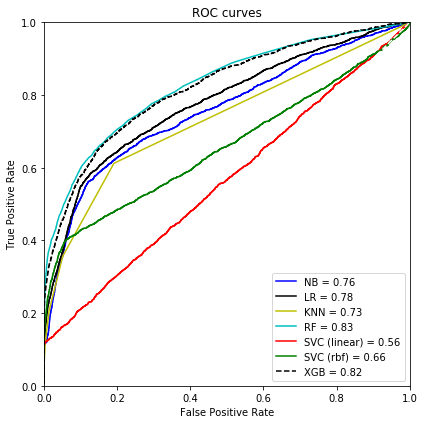

In [134]:
fig = plt.figure(figsize=(6, 6))
plt.title('ROC curves')
plt.plot(fpr_nb, tpr_nb, 'b', label = 'NB = %0.2f' % roc_auc_nb)
plt.plot(fpr_lr2, tpr_lr2, 'k', label = 'LR = %0.2f' % roc_auc_lr)
plt.plot(fpr_knn, tpr_knn, 'y', label = 'KNN = %0.2f' % roc_auc_knn)
plt.plot(fpr_rf2, tpr_rf2, 'c', label = 'RF = %0.2f' % roc_auc_rf2)
plt.plot(fpr_svc_linear, tpr_svc_linear, 'r', label = 'SVC (linear) = %0.2f' % roc_auc_svcl)
plt.plot(fpr_svc_rbf, tpr_svc_rbf, 'g', label = 'SVC (rbf) = %0.2f' % roc_auc_svcr)
plt.plot(fpr_xgb, tpr_xgb, 'k--', label = 'XGB = %0.2f' % roc_auc_xgb)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'w--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

<h1>Conclusion</h1>
<p>The goal of this assignment was to predict blight payment violations. Below is a summary of the best scored achieved by each classifier.</p>
<table>
    <tr>
        <th>Classifier</th>
        <th>ROC area</th>
    </tr>
    <tr>
        <td>Naive Bayes</td>
        <td>0.76</td>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>0.78</td>
    </tr>
    <tr>
        <td>KNN</td>
        <td>0.73</td>
    </tr>
    <tr>
        <td><strong>Random Forest</strong></td>
        <td><strong>0.83</strong></td>
    </tr>
    <tr>
        <td>SVC (linear)</td>
        <td>0.56</td>
    </tr>
    <tr>
        <td>SVC (rbf)</td>
        <td>0.66</td>
    </tr>    
    <tr>
        <td>Xtreme Gradient Boosting</td>
        <td>0.82</td>
    </tr>
</table>    
<p>To save on compute time, Grid search was performed on only Logistic regression, Random forest, and XGBoost. The best performing model was the Random Forest model.</p>

<h3>Future work</h3>
<p>A more extensive grid search could be done on all models.</p>